In [ ]:
!pip install stable-baselines3 optuna highway-env gymnasium

In [ ]:
import highway_env
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import TD3
import numpy as np
from gymnasium.spaces import Box

Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.
Computation Cost: 0s, Mean Reward: 29.91, Std Reward: 3.59, Mean Episode Length: 40.00 timesteps
Computation Cost: 0.01s, Mean Reward: 17.85, Std Reward: 7.56, Mean Episode Length: 40.00 timesteps
Computation Cost: 0.05s, Mean Reward: 15.44, Std Reward: 3.31, Mean Episode Length: 40.00 timesteps
Computation Cost: 0.1s, Mean Reward: 17.60, Std Reward: 5.00, Mean Episode Length: 40.00 timesteps
Computation Cost: 0.2s, Mean Reward: 19.42, Std Reward: 7.51, Mean Episode Length: 40.00 timesteps
Computation Cost: 0.5s, Mean Reward: 10.59, Std Reward: 7.06, Mean Episode Length: 40.00 timesteps
Computation Cost: 1s, Mean Reward: 13.60, Std Reward: 6.00, Mean Episode Length: 40.00 time

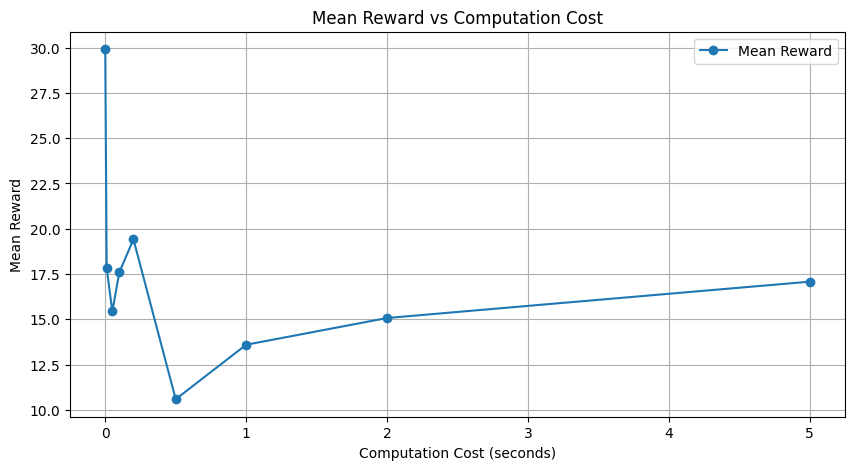

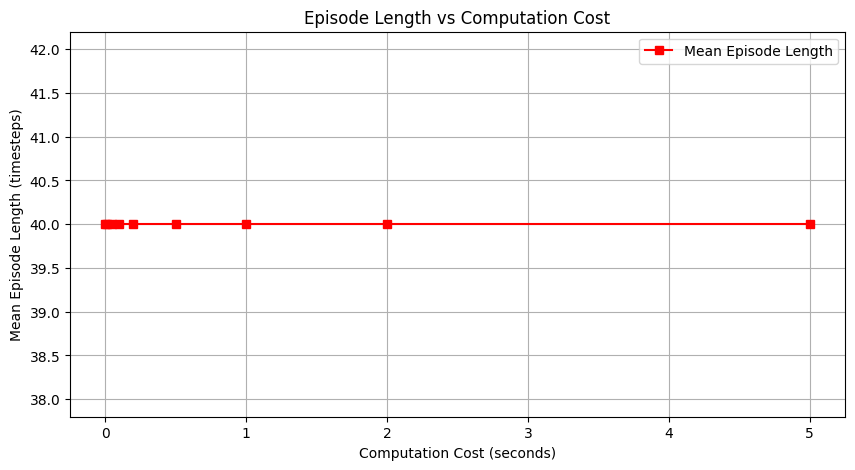

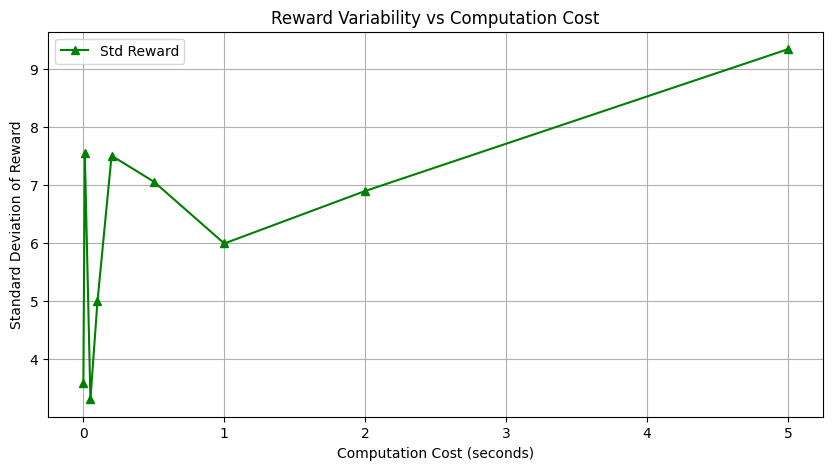

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor


def evaluate_with_computation_costs(computation_costs, model_path, n_eval_episodes=10):
    results = []

    for cost in computation_costs:
        # Create and wrap the environment with the custom computation delay
        env = gym.make("highway-v0")
        env.unwrapped.configure({
            "action": {
                "type": "ContinuousAction",  # Use continuous action space
            }
        })

        env = Monitor(env)  # Wrap with Monitor for logging
        env = AgentDelayWrapper(env, computation_cost=cost)  # Add computation delay here

        obs, info = env.reset()

        # Load the pre-trained model
        custom_objects = {"lr_schedule": lambda _: 0.001}
        model = SAC.load(model_path, custom_objects=custom_objects)
        model.set_env(env)  # Ensure the environment is set in the model

        # Evaluate the model
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, render=False)

        # Extract episode lengths
        episode_lengths = env.env.get_episode_lengths()
        mean_episode_length = np.mean(episode_lengths)

        # Store results
        results.append({
            'computation_cost': cost,
            'mean_reward': mean_reward,
            'std_reward': std_reward,
            'mean_episode_length': mean_episode_length
        })

        # Close the environment
        env.close()

    return results

# Set the range of computation costs to evaluate
computation_costs = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]

# Path to the pre-trained model
model_path = '/content/drive/MyDrive/SAC/sac_highway_45k.zip'

# Run the evaluations
results = evaluate_with_computation_costs(computation_costs, model_path)

# Print results
for result in results:
    print(f"Computation Cost: {result['computation_cost']}s, "
          f"Mean Reward: {result['mean_reward']:.2f}, "
          f"Std Reward: {result['std_reward']:.2f}, "
          f"Mean Episode Length: {result['mean_episode_length']:.2f} timesteps")

# ====== PLOT RESULTS ======

# Extract values from results
computation_costs = [res['computation_cost'] for res in results]
mean_rewards = [res['mean_reward'] for res in results]
std_rewards = [res['std_reward'] for res in results]
mean_episode_lengths = [res['mean_episode_length'] for res in results]

# Plot Mean Reward vs Computation Cost
plt.figure(figsize=(10, 5))
plt.plot(computation_costs, mean_rewards, marker='o', linestyle='-', label="Mean Reward")
plt.xlabel("Computation Cost (seconds)")
plt.ylabel("Mean Reward")
plt.title("Mean Reward vs Computation Cost")
plt.grid(True)
plt.legend()
plt.show()

# Plot Episode Length vs Computation Cost
plt.figure(figsize=(10, 5))
plt.plot(computation_costs, mean_episode_lengths, marker='s', linestyle='-', color='r', label="Mean Episode Length")
plt.xlabel("Computation Cost (seconds)")
plt.ylabel("Mean Episode Length (timesteps)")
plt.title("Episode Length vs Computation Cost")
plt.grid(True)
plt.legend()
plt.show()

# Plot Std Reward vs Computation Cost (Variability)
plt.figure(figsize=(10, 5))
plt.plot(computation_costs, std_rewards, marker='^', linestyle='-', color='g', label="Std Reward")
plt.xlabel("Computation Cost (seconds)")
plt.ylabel("Standard Deviation of Reward")
plt.title("Reward Variability vs Computation Cost")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ds

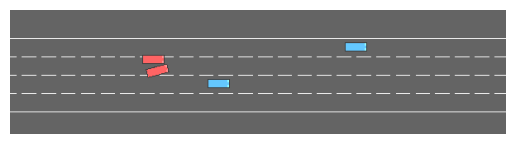

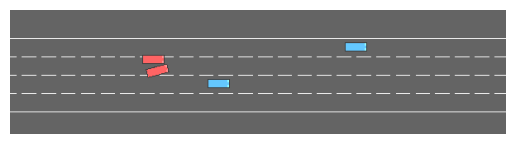

In [27]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

class ContinuousHighwayEnv(gym.Wrapper):
    def __init__(self, env, computation_delay=0.5):
        super(ContinuousHighwayEnv, self).__init__(env)
        self.action_space = Box(
            low=np.array([-1.0, -1.0]),  # Steering and acceleration
            high=np.array([1.0, 1.0]),   # Steering and acceleration
            dtype=np.float32
        )
        self.computation_cost = computation_delay  # Delay in seconds
        self.delayed_action = np.array([0.0, 0.0])  # Default action
        self.last_action_time = time.time()  # Time of last action update

    def step(self, action):
        current_time = time.time()

        if current_time - self.last_action_time >= self.computation_cost:
            # Only update action if enough time has passed
            self.delayed_action = action
            self.last_action_time = current_time  # Reset timer

        # Step the environment with the **last applied action**
        obs, reward, terminated, truncated, info = self.env.step(self._convert_to_discrete(self.delayed_action))
        return obs, reward, terminated, truncated, info

    def _convert_to_discrete(self, action):
        # Convert continuous action to discrete action
        steering, acceleration = action

        if steering < -0.5:
            discrete_action = 0  # Steer left
        elif steering > 0.5:
            discrete_action = 1  # Steer right
        else:
            if acceleration > 0:
                discrete_action = 2  # Accelerate
            elif acceleration < 0:
                discrete_action = 3  # Brake
            else:
                discrete_action = 4  # Do nothing

        return discrete_action

# Create the environment
env = gym.make('highway-v0', render_mode="rgb_array")
env = ContinuousHighwayEnv(env, computation_delay=5)  # Set computation delay to 0.5 seconds

# Reset the environment
obs, _ = env.reset()
done = False

# Run the simulation loop
while not done:
    # Sample a random action
    action = env.action_space.sample()

    # Take a step in the environment
    obs, reward, terminated, truncated, info = env.step(action)

    # Render the environment as an image
    frame = env.render()

    # Display the rendered frame
    plt.imshow(frame)
    plt.axis("off")
    clear_output(wait=True)  # Clear the previous frame
    display(plt.gcf())       # Display the current frame
    time.sleep(0.1)          # Pause to slow down rendering

    # Check if the episode is done
    done = terminated or truncated

# Close the environment
env.close()


In [29]:
from stable_baselines3 import TD3, SAC, DDPG

def evaluate_with_computation_costs(computation_costs, model_path, n_eval_episodes=10):
    results = []

    for cost in computation_costs:
        env = gym.make('highway-v0', render_mode="rgb_array")
        env = Monitor(env)  # Wrap with Monitor for logging
        env = ContinuousHighwayEnv(env, computation_delay=cost)  # Set computation delay to 0.5 seconds

        obs, info = env.reset()

        # Load the pre-trained model
        model = SAC.load(model_path, env=env)
        model.set_env(env)  # Ensure the environment is set in the model

        # Evaluate the model
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, render=False)

        # Extract episode lengths
        episode_lengths = env.env.get_episode_lengths()
        mean_episode_length = np.mean(episode_lengths)

        # Store results
        results.append({
            'computation_cost': cost,
            'mean_reward': mean_reward,
            'std_reward': std_reward,
            'mean_episode_length': mean_episode_length
        })

        # Close the environment
        env.close()

    return results

# Set the range of computation costs to evaluate
computation_costs = [0,0.2,1,3]

# Path to the pre-trained model
model_path = '/content/drive/MyDrive/Colab Notebooks/HIGHWAY/SAC/model_1.zip'

# Run the evaluations
results = evaluate_with_computation_costs(computation_costs, model_path)

# Print results
for result in results:
    print(f"Computation Cost: {result['computation_cost']}s, "
          f"Mean Reward: {result['mean_reward']:.2f}, "
          f"Std Reward: {result['std_reward']:.2f}, "
          f"Mean Episode Length: {result['mean_episode_length']:.2f} timesteps")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.
Computation Cost: 0s, Mean Reward: 19.48, Std Reward: 8.06, Mean Episode Length: 23.70 timesteps
Computation Cost: 0.2s, Mean Reward: 22.90, Std Reward: 9.13, Mean Episode Length: 28.90 timesteps
Computation Cost: 1s, Mean Reward: 16.71, Std Reward: 8.63, Mean Episode Length: 21.50 timesteps
Computation Cost: 3s, Mean Reward: 10.90, Std Reward: 10.73, Mean Episode Length: 14.30 timesteps
